# Static Mechanics Machine Learning Solver

Have you ever wondered if a machine learning model can predict how a mechanical structure deforms under a given load?

In this notebook, we will explore how machine learning models can be used to solve problems from structural mechanics, such as predicting the displacement of a structure under external forces.

Traditionally, such problems are solved using the finite element method (FEM), which requires detailed knowledge of the geometry, material properties, and boundary conditions. However, recent advances in data-driven modeling have opened the door to new approaches: using machine learning to approximate the solution of physical equations with smaller computing time!

But first, let's import all the libraries we'll need to build, train, and evaluate our models.


In [9]:
import time
import numpy as np
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, SGDRegressor, ElasticNet
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR

np.random.seed(42)

## Solving a Static Mechanical System

In this notebook, we solve a static linear elasticity problem using the finite element method (FEM). This type of problem describes the deformation $\mathbf{u}$ of a solid structure under an applied force field $\mathbf{f}$ over a spatial domain $\Omega$. The governing equation, assuming small deformations and linear elastic behavior, is:

$$
-\nabla \cdot \boldsymbol{\sigma} = \mathbf{f} \quad \text{in} \ \Omega,
$$

where:

* $\boldsymbol{\sigma}$ is the stress tensor,
* $\mathbf{f}$ is the external force per unit volume,
* $\Omega$ is the domain of the solid structure.

Under the assumption of linear elasticity (Hooke's law), the stress tensor is related to the displacement via:

$$
\boldsymbol{\sigma} = \mathbb{C} : \boldsymbol{\varepsilon}(\mathbf{u}),
$$

where:

* $\mathbf{u}$ is the displacement vector field (what we want to compute),
* $\mathbb{C}$ is the elasticity (or stiffness) tensor of the material,
* $\boldsymbol{\varepsilon}(\mathbf{u}) = \frac{1}{2}(\nabla \mathbf{u} + \nabla \mathbf{u}^\top)$ is the linearized strain tensor.

Substituting the stress-strain relationship into the equilibrium equation, and applying the weak (variational) form required for FEM, we obtain a linear system:

$$
\mathbb{K} \mathbf{u} = \mathbf{f},
$$

where:

* $\mathbb{K}$ is the global stiffness matrix, capturing the material properties and geometry of the structure,
* $\mathbf{u}$ is the vector of nodal displacements,
* $\mathbf{f}$ is the vector of external forces applied at each node.

Our goal will be to train a model to learn the mapping from force fields $\mathbf{f}$ to displacements $\mathbf{u}$, bypassing the need to explicitly solve the FEM system each time. 

### Example

In the code, we model a crane structure made of truss elements with a load applied at the tip of its arm. We assemble the stiffness matrix $\mathbb{K}$ and the force vector $\mathbf{f}$, then solve the system using a linear solver from `scipy`. This yields the displacement vector $\mathbf{u}$, which we use to visualize both the original and deformed shape of the structure.


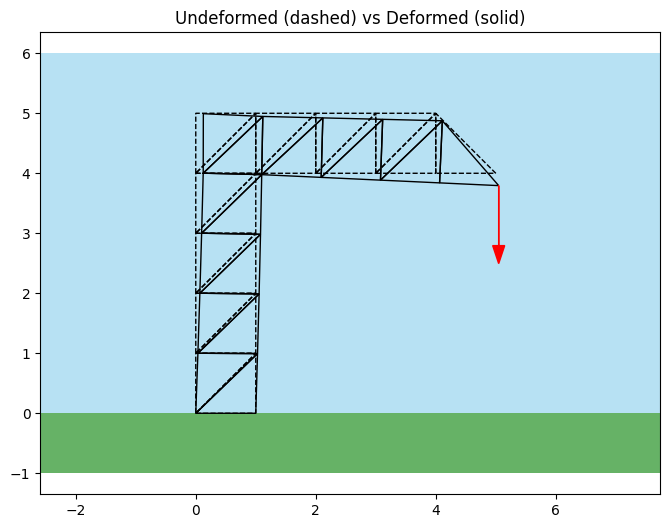

In [ ]:
# Material parameters
E = 210e9   # Young's modulus (Pa)
nu = 0.3    # Poisson's ratio


def geometry():
    nodes = np.array([
        [0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0],  # 1 vertical bloc
        [0.0, 2.0], [1.0, 2.0], [0.0, 3.0], [1.0, 3.0],  # 2 vertical bloc
        [0.0, 4.0], [1.0, 4.0], [0.0, 5.0], [1.0, 5.0],  # 3 vertical bloc
        [2.0, 4.0], [2.0, 5.0], [3.0, 4.0], [3.0, 5.0],  # 1 horizontal bloc
        [4.0, 4.0], [4.0, 5.0], [5.0, 4.0]               # 2 horizontal bloc
    ])
    
    elements = [
        [0, 1, 3], [0, 2, 3],
        [2, 3, 5], [2, 4, 5],
        [4, 5, 7], [4, 6, 7],
        [6, 7, 9], [6, 8, 9],
        [8, 9, 11], [8, 10, 11],
        [9, 12, 13], [9, 11, 13],
        [12, 14, 15], [12, 13, 15],
        [14, 16, 17], [14, 15, 17],
        [16, 17, 18]
    ]

    n_nodes = nodes.shape[0]
    dof = 2 * n_nodes
    dofs = np.arange(dof)
    
    # Boundary conditions: fix nodes at y=0
    fixed_nodes = [i for i, (_, y) in enumerate(nodes) if y == 0]
    fixed_dofs = [dof for n in fixed_nodes for dof in (2*n, 2*n+1)]
    free_dofs = np.setdiff1d(dofs, fixed_dofs)
    
    return elements, nodes, dof, free_dofs


def get_ke(xy):
    # Linear triangular element
    x1, y1 = xy[0]
    x2, y2 = xy[1]
    x3, y3 = xy[2]
    A = 0.5 * np.linalg.det(np.array([[1, x1, y1], [1, x2, y2], [1, x3, y3]]))
    B = np.zeros((3, 6))
    b = np.array([y2 - y3, y3 - y1, y1 - y2])
    c = np.array([x3 - x2, x1 - x3, x2 - x1])
    B[0, 0::2] = b
    B[1, 1::2] = c
    B[2, 0::2] = c
    B[2, 1::2] = b
    B = B / (2 * A)
    # constitutive matrix D
    coef = E / ((1 + nu) * (1 - 2 * nu))
    D = coef * np.array([[1 - nu, nu, 0], [nu, 1 - nu, 0], [0, 0, (1 - 2 * nu) / 2]])
    Ke = A * (B.T @ D @ B)
    return Ke


def get_K(dof, free_dofs, nodes, elements):
    K = sp.sparse.lil_matrix((dof, dof))
    for el in elements:
        xy = nodes[el]
        ke = get_ke(xy)
        for i in range(3):
            for j in range(3):
                ni = el[i]
                nj = el[j]
                K[2*ni:2*ni+2, 2*nj:2*nj+2] += ke[2*i:2*i+2, 2*j:2*j+2]
    K = K[np.ix_(free_dofs, free_dofs)]
    return K


def get_f(dof, free_dofs, node, force):
    f = np.zeros(dof)
    f[node] = force  # in Newton
    f = f[free_dofs]
    return f.flatten()


# Compute geometry, stiffness matrix K and force vector f
elements, nodes, dof, free_dofs = geometry()
K = get_K(dof, free_dofs, nodes, elements)
f = get_f(dof, free_dofs, node=-3, force=-5e8)



# Solve the FEM equation
u_free = sp.sparse.linalg.spsolve(K.tocsr(), f).real



# Reformat and scale displacement u
u = np.zeros(dof)
u[free_dofs] = u_free
nodes_def = nodes + u.reshape(-1, 2)



# Plot
def plot_mesh(nodes, elements, **kwargs):
    for tri in elements:
        pts = nodes[tri]
        plt.fill(pts[:, 0], pts[:, 1], edgecolor='k', fill=False, **kwargs)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhspan(-1, 0, facecolor='green', alpha=0.6)
ax.axhspan(0, 6, facecolor='skyblue', alpha=0.6)
plot_mesh(nodes, elements, linestyle='--') # original
plot_mesh(nodes_def, elements, linestyle='-') # deformed
ax.arrow(nodes_def[-1][0], nodes_def[-1][1], 0, -1, head_width=0.2, head_length=0.3, fc='red', ec='red')
plt.title('Undeformed (dashed) vs Deformed (solid)')
plt.axis('equal')
plt.show()

## Dataset creation

Now, we want to train a model able to generate these displacement fields from the force vector. To do so, we have to create a synthetic database containing the input force vector and output displacement fields on the crane. To create the dataset, we implemented the generate_dataset function that creates all possible force vector with one non-zero value placed on one of the nodes.

For each force vector, we compute the associated displacement field by solving the FEM system with a classical library (Scipy sparse). Sparse means the matrix K has a majority of null values and the resolution can be spead up with the scipy sparse solver. We have at the end two lists of matrices, X which contains force vectors, and Y which contains displacement field solutions.

Finally, we nomalize X and Y fields and we separate each dataset in a train and a test datasets.

In [20]:

def generate_dataset(num):
    X = []
    Y = []
    for value in tqdm(list(np.linspace(-1e-3, 1e-3, num=num, endpoint=True))): 
        for node in range(dof):
            f = get_f(dof, free_dofs, node, value)
            u = sp.sparse.linalg.spsolve(K.tocsr(), f).real 
            X.append(f)
            Y.append(u)
    return X, Y


start = time.perf_counter()
X, Y = generate_dataset(1000)
end = time.perf_counter()
exe_time = end - start          
print(f"Execution time: {exe_time:.2f}s") 

print(np.shape(X), np.shape(Y))

X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=True)

100%|██████████| 1000/1000 [00:06<00:00, 159.72it/s]


Execution time: 6.27s
(38000, 34) (38000, 34)


## Training

It's time to train the model! We calculate their R2 scores and RMSE relative to the test dataset. Finally, we plot some randomly chosen displacement fields calculated by Finite Elements to compare them with Machine Learning calculated displacement fields. Surprisingly, the model with higher precision is Skicit-learn's Linear Regression with a relative error of $10^{-15}$.

Training time: 0.29s

Model's R2 score : 1.0
FINAL RMSE: 2.2564952210778916e-15 



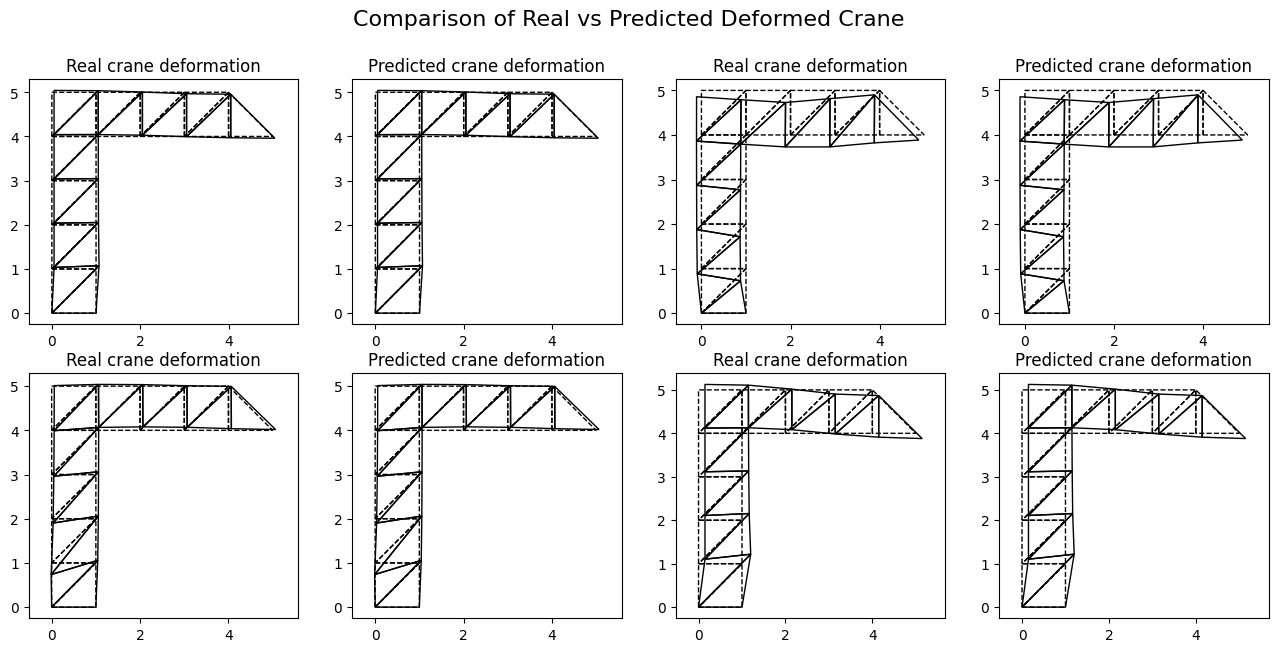

In [18]:
model = LinearRegression(n_jobs=-1) 

start = time.perf_counter()
history = model.fit(X_train, Y_train)
end = time.perf_counter()
exe_time = end - start          
print(f"Training time: {exe_time:.2f}s\n") 



### EVALUATION
score = model.score(X_test, Y_test)
print("Model's R2 score :", score)

Y_predict = model.predict(X_test) 
print('FINAL RMSE:', np.sqrt(mean_squared_error(Y_test, Y_predict)), '\n')




## PLOT RANDOM PREDICTIONS
fig, ax = plt.subplots(2, 4, figsize=(16, 7))
fig.suptitle("Comparison of Real vs Predicted Deformed Crane", fontsize=16)

for idx, i in enumerate([28, 47, 123, 402]):
    plt.subplot(241 + 2*idx)
    u = np.zeros(dof)
    u[free_dofs] = Y_test[i]
    nodes_def = nodes + u.reshape(-1, 2)
    plot_mesh(nodes, elements, linestyle='--') # original
    plot_mesh(nodes_def, elements, linestyle='-') # deformed
    plt.title('Real crane deformation')
    plt.axis('equal')
    
    plt.subplot(242 + 2*idx)
    u = np.zeros(dof)
    u[free_dofs] = Y_predict[i]
    nodes_def = nodes + u.reshape(-1, 2)
    plot_mesh(nodes, elements, linestyle='--') # original
    plot_mesh(nodes_def, elements, linestyle='-') # deformed
    plt.title('Predicted crane deformation')
    plt.axis('equal')

plt.show()


## Inference time

One interesting result is that the inference time of the model is faster than the classical matrix resolution, which can be useful for many applications, for example in the industry.

In [27]:
import timeit
f = X_test[120].reshape(-1, 1)

exe_time_spa = np.array(timeit.repeat('sp.sparse.linalg.spsolve(K.tocsr(), f)', globals=globals(), number=100, repeat=100)) / 1e2
exe_time_mod = np.array(timeit.repeat('model.predict(f.reshape(1, -1))', globals=globals(), number=100, repeat=100)) / 1e2

print(f"FEM resolution execution time : {(np.mean(exe_time_spa)/1e-3):.3f} ms, variance : {(np.var(exe_time_spa)/1e-9):.2f} ns")
print(f"ML model execution time       : {(np.mean(exe_time_mod)/1e-3):.3f} ms, variance : {(np.var(exe_time_mod)/1e-9):.2f} ns")


FEM resolution execution time : 0.158 ms, variance : 14.27 ns
ML model execution time       : 0.050 ms, variance : 0.06 ns
